In [1]:
import pandas as pd
import numpy as np
from numpy import nanargmax
from numpy import argmax

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.naive_bayes import BernoulliNB
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, LinearRegression
LogReg=LogisticRegression()
LinReg=LinearRegression()

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc

from sklearn.manifold import LocallyLinearEmbedding
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from scikeras.wrappers import KerasClassifier

from sklearn.utils.class_weight import compute_sample_weight
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure


import janitor

import warnings
warnings.filterwarnings('ignore')

C:\Users\xysti\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\xysti\AppData\Local\Temp\ipykernel_12728\2975232278.py:34: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


##  1. DATA PREPARATION 

In [87]:
# IMPORT DATA
df = pd.read_excel('D:/Angelo/DTU/Thesis/Data/PMS_Data_SMC_IN.xlsx')

In [89]:
df['NEXT_DUE_DATE'] =  pd.to_datetime(df['NEXT_DUE_DATE'], errors = 'coerce', format='%Y-%m-%d %H:%M:%S%f')

In [90]:
# CHECK COLUMNS
df.columns
df = df.drop(columns=['TBO acc. MAN (hrs)', 'Manager', 'JOB_TITLE', 'Comment'])

# TRIM TEXT
cols = df.select_dtypes(object).columns
df[cols] = df[cols].apply(lambda x: x.str.strip())

In [91]:
### 1. TAKE ROWS WITH NEXT DUE DATE IN 2022 AND CREATE NEW DATA
df_temp = df[(df['NEXT_DUE_DATE'] < '2022-12-31')]
# DROP COLUMNS LAST DATE
df_temp = df_temp.drop(columns=['LAST_DONE_DATE', 'LAST_DONE_HRS'])
# RENAME COLUMNS
df_temp = df_temp.rename(columns={"NEXT_DUE_DATE": "LAST_DONE_DATE", "NEXT_DUE_HRS": "LAST_DONE_HRS"})
'''

'''
### 2. APPEND NEW DATA TO MAIN DATAFRAME
# DELETE UNWANTED COLUMNS
df = df.drop(columns=['NEXT_DUE_DATE', 'NEXT_DUE_HRS'])
# APPEND TWO DATASETS
df = df.append(df_temp)

In [92]:
# Rename date column
df = df.rename(columns={"LAST_DONE_DATE": "Maintenance_Date", "LAST_DONE_HRS": "Running_Hours"})
df

,VESSEL_NAME,EQUIPMENT_NAME,EQUIPMENT_CODE,FREQUENCY,JOB_TYPE,Maintenance_Date,Running_Hours
0,Aqua Bonanza,ME FUEL INJECTOR NO.2B,601.01.09.02.02.02,8000,Overhaul,2020-12-11,68693.0
1,Aqua Bonanza,ME FUEL INJECTOR NO.2B,601.01.09.02.02.02,16000,Overhaul,2020-12-11,68693.0
2,Aqua Bonanza,ME FUEL INJECTOR NO.2B,601.01.09.02.02.02,4000,Inspection,2021-07-13,71960.0
3,Aqua Bonanza,ME FUEL INJECTOR NO.3B,601.01.09.02.03.02,4000,Inspection,2021-08-03,72037.0
4,Aqua Bonanza,ME FUEL INJECTOR NO.3B,601.01.09.02.03.02,16000,Overhaul,2020-10-27,67792.0
...,...,...,...,...,...,...,...
3372,Zoe Schulte,ME CYLINDER LINER NO.4,601.01.04.04,12000,Calibration,2022-05-02,25281.0
3376,Zoe Schulte,ME PISTON AND RINGS NO.1,601.01.03.01,12000,Overhaul,2022-02-03,24525.0
3377,Zoe Schulte,ME PISTON ROD & STUFFING BOX NO.1,601.01.02.01,12000,Overhaul,2022-02-03,24525.0
3379,Zoe Schulte,ME PISTON ROD & STUFFING BOX NO.3,601.01.02.03,12000,Overhaul,2022-12-10,27204.0


In [93]:
### 3. DROP NON-OVERHAULS
df = (df[df['JOB_TYPE'] == 'Overhaul'] )
df = df.drop(columns=['JOB_TYPE'])

In [94]:
### 4. CREATE CONDITIONAL COLUMN (MAINTENANCE KIT) BASED ON EQUIPMENT
df['Maintenance_Kit'] = pd.np.where(df.EQUIPMENT_CODE.str.contains("601.01.03."), "Piston Ring CR", 
                                    pd.np.where(df.EQUIPMENT_CODE.str.contains("601.01.02."), "Stuff. Box MK",
                                    pd.np.where(df.EQUIPMENT_CODE.str.contains("601.01.09.01.01."), "Fuel Pump",
                                    pd.np.where(df.EQUIPMENT_CODE.str.contains("601.01.10.01.01"), "Alpha Lub",
                                    pd.np.where(df.EQUIPMENT_CODE.str.contains("601.01.04."), "Cyl. Liner",
                                    pd.np.where(df.EQUIPMENT_CODE.str.contains("601.01.01"), "Cyl. Cover",
                                    pd.np.where(df.EQUIPMENT_CODE.str.contains("601.01.12.01"), "Exh. Valve Act",
                                    pd.np.where(df.EQUIPMENT_CODE.str.contains("601.01.09.01.02"), "Press. Booster",
                                    pd.np.where(df.EQUIPMENT_CODE.str.contains("601.01.09.02."), "Fuel Valve (16.000 hrs)",
                                    pd.np.where(df.EQUIPMENT_CODE.str.contains("601.01.20.01.04."), "Accumulators ME",
                                    pd.np.where(df.EQUIPMENT_CODE.str.contains("601.01.20.01.01."), "Proportional Valve HydrPump ME",
                                    pd.np.where(df.EQUIPMENT_CODE.str.contains("601.01.20.01.03."), "Hydr. Cyl. Unit",
                                    pd.np.where(df.EQUIPMENT_CODE.str.contains("651."), "Auxiliary Engine MK",
                                    pd.np.where(df.EQUIPMENT_CODE.str.contains("601.01.15.01"), "Turbocharger",
                                    "N/A"))))))))))))))


In [95]:
### 5: CREATE CYLINDER NUMBER AND INJECTOR NUMBER COLUMN
# The column "EQUIPMENT_NAME" contains spaces sometimes after NO. - We remove those spaces
df['EQUIPMENT_NAME'] = df['EQUIPMENT_NAME'].str.replace('NO. ','NO.')

# Take the 2 numbers after NO.
df['TEMP_COL'] = df.EQUIPMENT_NAME.str.extract('\.(.{,2})') 
# split temporary column
df[['A', 'Cylinder_Number', 'Injector_Number', 'D']] = df['TEMP_COL'].str.split('',expand=True)
# Drop unwanted columns
df = df.drop(columns=['A', 'D', 'TEMP_COL'])

In [96]:
df

,VESSEL_NAME,EQUIPMENT_NAME,EQUIPMENT_CODE,FREQUENCY,Maintenance_Date,Running_Hours,Maintenance_Kit,Cylinder_Number,Injector_Number
0,Aqua Bonanza,ME FUEL INJECTOR NO.2B,601.01.09.02.02.02,8000,2020-12-11,68693.0,Fuel Valve (16.000 hrs),2,B
1,Aqua Bonanza,ME FUEL INJECTOR NO.2B,601.01.09.02.02.02,16000,2020-12-11,68693.0,Fuel Valve (16.000 hrs),2,B
4,Aqua Bonanza,ME FUEL INJECTOR NO.3B,601.01.09.02.03.02,16000,2020-10-27,67792.0,Fuel Valve (16.000 hrs),3,B
5,Aqua Bonanza,ME FUEL INJECTOR NO.3B,601.01.09.02.03.02,8000,2020-10-27,67792.0,Fuel Valve (16.000 hrs),3,B
6,Aqua Bonanza,ME FUEL INJECTOR NO.4B,601.01.09.02.04.02,16000,2020-10-27,67792.0,Fuel Valve (16.000 hrs),4,B
...,...,...,...,...,...,...,...,...,...
3366,Zoe Schulte,ME CYLINDER COVER NO.4,601.01.01.04,12000,2022-05-02,25281.0,Cyl. Cover,4,
3376,Zoe Schulte,ME PISTON AND RINGS NO.1,601.01.03.01,12000,2022-02-03,24525.0,Piston Ring CR,1,
3377,Zoe Schulte,ME PISTON ROD & STUFFING BOX NO.1,601.01.02.01,12000,2022-02-03,24525.0,Stuff. Box MK,1,
3379,Zoe Schulte,ME PISTON ROD & STUFFING BOX NO.3,601.01.02.03,12000,2022-12-10,27204.0,Stuff. Box MK,3,


In [97]:
### 6. REMOVE ROWS THAT CONTAIN INDICATOR VALVE OR SAFETY VALVE (THEY ARE CONSIDERED OBSOLETE)   
df = df[df["EQUIPMENT_NAME"].str.contains("INDICATOR VALVE") == False]
df = df[df["EQUIPMENT_NAME"].str.contains("SAFETY VALVE") == False]

### 7. CREATE MAINTENANCE YEAR
df['maintainance_year'] = df['Maintenance_Date'].dt.year

<AxesSubplot:title={'center':'Count of jobs done per year'}, xlabel='Year', ylabel='Count'>

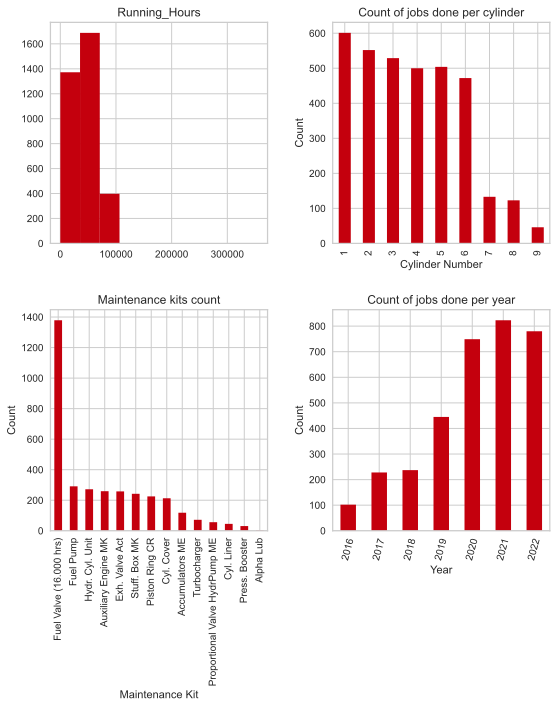

In [98]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8,8))
fig.tight_layout(pad=2)

df.hist('Running_Hours', ax=axes[0,0],  color = [(0.77,0,0.05)])
#df['VESSEL_NAME'].value_counts().plot(kind='bar',title = 'Maintenance kits count', xlabel='Maintenance Kit', ylabel='Count', rot=90, ax=axes[0,0])
df['Cylinder_Number'].value_counts(sort=True).loc[['1', '2', '3','4', '5', '6','7', '8', '9']].plot(kind='bar', title = 'Count of jobs done per cylinder', xlabel='Cylinder Number', ylabel='Count', rot=90, ax=axes[0,1], color = [(0.77,0,0.05)])
df['Maintenance_Kit'].value_counts().plot(kind='bar',title = 'Maintenance kits count', xlabel='Maintenance Kit', ylabel='Count', rot=90, ax=axes[1,0],  color = [(0.77,0,0.05)])
df['maintainance_year'].value_counts(sort=False).loc[[2016, 2017, 2018,2019, 2020, 2021,2022]].plot(kind='bar', title = 'Count of jobs done per year', xlabel='Year', ylabel='Count', rot=75, ax=axes[1,1],  color = [(0.77,0,0.05)])

In [99]:
# ADD INJECTOR NUMBER TO MAINTENANCE KIT
df["Maintenance_Kit"] = df['Maintenance_Kit'].astype(str) +" "+ df["Injector_Number"]

In [100]:
### 8. REMOVE DUPLICATE ROWS
df = df.drop_duplicates(['VESSEL_NAME','Maintenance_Kit','Cylinder_Number', 'Injector_Number','maintainance_year', 'EQUIPMENT_CODE'], keep='last')

### 9. THERE ARE A FEW ROWS WITH NAN (4 rows) - WE REMOVE THEM 
df.isna().sum().sum()
df=df.dropna(axis=0)
df

,VESSEL_NAME,EQUIPMENT_NAME,EQUIPMENT_CODE,FREQUENCY,Maintenance_Date,Running_Hours,Maintenance_Kit,Cylinder_Number,Injector_Number,maintainance_year
1,Aqua Bonanza,ME FUEL INJECTOR NO.2B,601.01.09.02.02.02,16000,2020-12-11,68693.0,Fuel Valve (16.000 hrs) B,2,B,2020
5,Aqua Bonanza,ME FUEL INJECTOR NO.3B,601.01.09.02.03.02,8000,2020-10-27,67792.0,Fuel Valve (16.000 hrs) B,3,B,2020
7,Aqua Bonanza,ME FUEL INJECTOR NO.4B,601.01.09.02.04.02,8000,2020-10-27,67792.0,Fuel Valve (16.000 hrs) B,4,B,2020
11,Aqua Bonanza,ME FUEL INJECTOR NO.5B,601.01.09.02.05.02,8000,2021-03-08,70121.0,Fuel Valve (16.000 hrs) B,5,B,2021
14,Aqua Bonanza,ME FUEL INJECTOR NO.6B,601.01.09.02.06.02,8000,2020-12-11,68693.0,Fuel Valve (16.000 hrs) B,6,B,2020
...,...,...,...,...,...,...,...,...,...,...
3366,Zoe Schulte,ME CYLINDER COVER NO.4,601.01.01.04,12000,2022-05-02,25281.0,Cyl. Cover,4,,2022
3376,Zoe Schulte,ME PISTON AND RINGS NO.1,601.01.03.01,12000,2022-02-03,24525.0,Piston Ring CR,1,,2022
3377,Zoe Schulte,ME PISTON ROD & STUFFING BOX NO.1,601.01.02.01,12000,2022-02-03,24525.0,Stuff. Box MK,1,,2022
3379,Zoe Schulte,ME PISTON ROD & STUFFING BOX NO.3,601.01.02.03,12000,2022-12-10,27204.0,Stuff. Box MK,3,,2022


In [101]:
### 7. WE WILL PREDICT EACH VALVE MAINTENANCE SEPARATELY

# TRIM TEXT
cols = df.select_dtypes(object).columns
df[cols] = df[cols].apply(lambda x: x.str.strip())

#1. DROP NOT NEEDED COLUMNS
df = df.drop(columns=['EQUIPMENT_NAME', 'EQUIPMENT_CODE', 'Injector_Number'])

# 2. ADD OUTPUT COLUMN (IF A MAINTENANCE OCCURED)
df['done'] = 1

# 3. DELETE MAINTENANCE FROM 2015 AND BEFORE (if I keep them I will have ca.190000 rows)
df = df[df['maintainance_year'] > 2015]  


# 4. REMOVE ALPHA LUB FROM PREDICTION (THEY OCCUR TOO FEW (2) TIMES - WE WON'T PREDICT THIS TYPE)
#    OPTIONALLY, REMOVE AUXILARY ENGINE KITS (MIGHT HELP THE PREDICTION)
df = df[df['Maintenance_Kit'] != 'Alpha Lub']
df = df[df['Maintenance_Kit'] != 'Auxiliary Engine MK'] 

frequency column is inconsistent, might cause problems to the models

In [102]:
### 5. DROP NOT NEEDED COLUMNS
df = df.drop(columns=['FREQUENCY'])

In [103]:
df

,VESSEL_NAME,Maintenance_Date,Running_Hours,Maintenance_Kit,Cylinder_Number,maintainance_year,done
1,Aqua Bonanza,2020-12-11,68693.0,Fuel Valve (16.000 hrs) B,2,2020,1
5,Aqua Bonanza,2020-10-27,67792.0,Fuel Valve (16.000 hrs) B,3,2020,1
7,Aqua Bonanza,2020-10-27,67792.0,Fuel Valve (16.000 hrs) B,4,2020,1
11,Aqua Bonanza,2021-03-08,70121.0,Fuel Valve (16.000 hrs) B,5,2021,1
14,Aqua Bonanza,2020-12-11,68693.0,Fuel Valve (16.000 hrs) B,6,2020,1
...,...,...,...,...,...,...,...
3366,Zoe Schulte,2022-05-02,25281.0,Cyl. Cover,4,2022,1
3376,Zoe Schulte,2022-02-03,24525.0,Piston Ring CR,1,2022,1
3377,Zoe Schulte,2022-02-03,24525.0,Stuff. Box MK,1,2022,1
3379,Zoe Schulte,2022-12-10,27204.0,Stuff. Box MK,3,2022,1


In [104]:
df = df[df['Running_Hours'] <= 200000]

<AxesSubplot:title={'center':'Count of jobs done per year'}, xlabel='Year', ylabel='Count'>

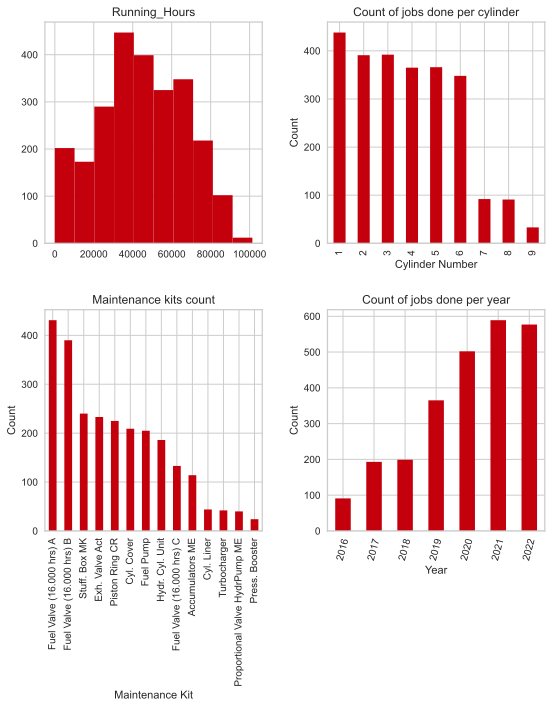

In [105]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8,8))
fig.tight_layout(pad=2)

df.hist('Running_Hours', ax=axes[0,0],  color = [(0.77,0,0.05)])
#df['VESSEL_NAME'].value_counts().plot(kind='bar',title = 'Maintenance kits count', xlabel='Maintenance Kit', ylabel='Count', rot=90, ax=axes[0,0])
df['Cylinder_Number'].value_counts(sort=True).loc[['1', '2', '3','4', '5', '6','7', '8', '9']].plot(kind='bar', title = 'Count of jobs done per cylinder', xlabel='Cylinder Number', ylabel='Count', rot=90, ax=axes[0,1], color = [(0.77,0,0.05)])
df['Maintenance_Kit'].value_counts().plot(kind='bar',title = 'Maintenance kits count', xlabel='Maintenance Kit', ylabel='Count', rot=90, ax=axes[1,0],  color = [(0.77,0,0.05)])
df['maintainance_year'].value_counts(sort=False).loc[[2016, 2017, 2018,2019, 2020, 2021,2022]].plot(kind='bar', title = 'Count of jobs done per year', xlabel='Year', ylabel='Count', rot=75, ax=axes[1,1],  color = [(0.77,0,0.05)])

   ## 2. DATA PRE-PROCESSING

In [106]:
### 1. ADD ROWS WITH ALL THE POSSIBLE MAINTENANE TYPES FOR EACH CYLINDER FOR EACH YEAR
df = df.complete('VESSEL_NAME', 'Maintenance_Kit', 'Cylinder_Number', 'maintainance_year').fillna(0, downcast='infer')
# Sort the data to have better view
df = df.sort_values(['VESSEL_NAME', 'Cylinder_Number', 'maintainance_year'],
             ascending = [True, True, True])

df = df.reset_index(drop=True)

In [107]:
### 2. THE CREATED ROWS EXCEED THE CORRECT AMOUNT OF ENGINES/CYLIDERS, WE HAVE TO DELETE THEM MANULLY
df = df.astype({"Cylinder_Number": int})
df = df[(df.VESSEL_NAME == 'Aqua Bonanza') & (df.Cylinder_Number <= 6) | 
        (df.VESSEL_NAME == 'Central') & (df.Cylinder_Number <= 6) |
        (df.VESSEL_NAME == 'Clamor Schulte') & (df.Cylinder_Number <= 6) |
        (df.VESSEL_NAME == 'Clover') & (df.Cylinder_Number <= 6) |
        (df.VESSEL_NAME == 'Donata Schulte') & (df.Cylinder_Number <= 6) |
        (df.VESSEL_NAME == 'Dorothea Schulte') & (df.Cylinder_Number <= 6) |
        (df.VESSEL_NAME == 'Hans Schulte') & (df.Cylinder_Number <= 8) |
        (df.VESSEL_NAME == 'Hedwig Schulte') & (df.Cylinder_Number <= 8) |
        (df.VESSEL_NAME == 'Hyde') & (df.Cylinder_Number <= 6) |
        (df.VESSEL_NAME == 'Jasper Dream') & (df.Cylinder_Number <= 6) |
        (df.VESSEL_NAME == 'Key Sonority') & (df.Cylinder_Number <= 6) |
        (df.VESSEL_NAME == 'Konrad Schulte') & (df.Cylinder_Number <= 6) |
        (df.VESSEL_NAME == 'LILA II') & (df.Cylinder_Number <= 6) |
        (df.VESSEL_NAME == 'Largo Mariner') & (df.Cylinder_Number <= 6) |
        (df.VESSEL_NAME == 'London Courage') & (df.Cylinder_Number <= 6) |
        (df.VESSEL_NAME == 'MSC Agadir') & (df.Cylinder_Number <= 9) |
        (df.VESSEL_NAME == 'MSC Antigua') & (df.Cylinder_Number <= 9) |
        (df.VESSEL_NAME == 'Margarete Schulte') & (df.Cylinder_Number <= 8) |
        (df.VESSEL_NAME == 'Moritz Schulte') & (df.Cylinder_Number <= 6) |
        (df.VESSEL_NAME == 'PPS Luck') & (df.Cylinder_Number <= 6) |
        (df.VESSEL_NAME == 'PPS Salmon') & (df.Cylinder_Number <= 6) |
        (df.VESSEL_NAME == 'Thalea Schulte') & (df.Cylinder_Number <= 6) |
        (df.VESSEL_NAME == 'Thekla Schulte') & (df.Cylinder_Number <= 5) |
        (df.VESSEL_NAME == 'Theresa Schulte') & (df.Cylinder_Number <= 5) |
        (df.VESSEL_NAME == 'United Crown') & (df.Cylinder_Number <= 6) |
        (df.VESSEL_NAME == 'Weser Stahl') & (df.Cylinder_Number <= 6) |
        (df.VESSEL_NAME == 'Zita Schulte') & (df.Cylinder_Number <= 6) |
        (df.VESSEL_NAME == 'Zoe Schulte') & (df.Cylinder_Number <= 6) ]


In [108]:
### 3. CREATE COLUMN WITH AVG RUNNING HOURS
# WE ADD THE RUNNING HOUR INSTANCES PER VESSEL, PER YEAR AND DIVIDE BY THEIR NUMBER
df['Running_Hours'] = df.replace(0, np.nan).groupby(['VESSEL_NAME', 'maintainance_year'])['Running_Hours'].transform('mean') 

df['Running_Hours'].isna().sum()


### 4. FILL NA VALUES WITH AVG OF PREVIOUS AND NEXT
# rearrange the dataframe
df = df.sort_values(['VESSEL_NAME', 'maintainance_year'],
              ascending = [True, True])



# fill na in running hours with the mean of previous-next years, per vessel
df = (df.assign(ffill = df.groupby('VESSEL_NAME').Running_Hours.ffill(),
                 bfill = df.groupby('VESSEL_NAME').Running_Hours.bfill(),
                 both  = df.groupby('VESSEL_NAME').Running_Hours.ffill().add(df.Running_Hours.bfill()),
                 fin = df.groupby('VESSEL_NAME').Running_Hours.ffill().add(df.Running_Hours.bfill()).div(2)))
df['Running_Hours'] = df['Running_Hours'].fillna(df['fin'])



#  for the vessels that still don't have, we apply the running hours from the next year 
df.loc[df['maintainance_year'] == 2016 ,'Running_Hours'] = df.loc[df['maintainance_year'] == 2016,'Running_Hours'].fillna(value = (df['bfill']))
df.loc[df['maintainance_year'] == 2017 ,'Running_Hours'] = df.loc[df['maintainance_year'] == 2017,'Running_Hours'].fillna(value = df['bfill'])
df.loc[df['maintainance_year'] == 2018 ,'Running_Hours'] = df.loc[df['maintainance_year'] == 2018,'Running_Hours'].fillna(value = df['bfill'])
df.loc[df['maintainance_year'] == 2019 ,'Running_Hours'] = df.loc[df['maintainance_year'] == 2019,'Running_Hours'].fillna(value = df['bfill'])

In [109]:
### 5. DROP NOT NEEDED COLUMNS
df = df.drop(columns=['ffill', 'bfill', 'both', 'fin', 'Maintenance_Date'])

,VESSEL_NAME,Running_Hours,Maintenance_Kit,Cylinder_Number,maintainance_year,done
0,Aqua Bonanza,47193.000000,Fuel Valve (16.000 hrs) B,1,2016,0
1,Aqua Bonanza,47193.000000,Cyl. Cover,1,2016,0
2,Aqua Bonanza,47193.000000,Exh. Valve Act,1,2016,0
3,Aqua Bonanza,47193.000000,Fuel Valve (16.000 hrs) A,1,2016,0
4,Aqua Bonanza,47193.000000,Fuel Pump,1,2016,0
...,...,...,...,...,...,...
23586,Zoe Schulte,25262.428571,Hydr. Cyl. Unit,6,2022,0
23587,Zoe Schulte,25262.428571,Press. Booster,6,2022,0
23588,Zoe Schulte,25262.428571,Fuel Valve (16.000 hrs) C,6,2022,0
23589,Zoe Schulte,25262.428571,Proportional Valve HydrPump ME,6,2022,0


In [110]:
# SAVE PROGRESS
df1 = df.copy()

#### ONE HOT ENCODING

In [112]:
#df=df1.copy()
# change data types
df = df.astype({"Cylinder_Number": object, "maintainance_year": object})



### 1. ONE-OUT-OF K ENCODING
df = pd.get_dummies(df, prefix = '', prefix_sep='')


In [113]:
df

,Running_Hours,done,Aqua Bonanza,Central,Clamor Schulte,Clover,Donata Schulte,Dorothea Schulte,Hans Schulte,Hedwig Schulte,...,7,8,9,2016,2017,2018,2019,2020,2021,2022
0,47193.000000,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,47193.000000,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,47193.000000,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,47193.000000,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,47193.000000,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23586,25262.428571,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
23587,25262.428571,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
23588,25262.428571,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
23589,25262.428571,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


## Predictions for one complete year

In this notebook we predict 2022

In [114]:
X_train = (df[df['2022'] != 1] )
X_test = (df[df['2022'] == 1] )

### 5. RESET INDEX
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

In [115]:
X_train

,Running_Hours,done,Aqua Bonanza,Central,Clamor Schulte,Clover,Donata Schulte,Dorothea Schulte,Hans Schulte,Hedwig Schulte,...,7,8,9,2016,2017,2018,2019,2020,2021,2022
0,47193.0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,47193.0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,47193.0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,47193.0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,47193.0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14501,20825.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
14502,20825.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
14503,20825.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
14504,20825.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [116]:
y_train = X_train['done']
y_test = X_test['done']
X_train = X_train.drop('done', axis=1)
X_test = X_test.drop('done', axis=1)



### 4. STANDARDIZE TEST/TRAIN SETS (only continuous)
X_train['Running_Hours'] = StandardScaler().fit_transform(np.array(X_train['Running_Hours']).reshape(-1,1))
X_test['Running_Hours'] = StandardScaler().fit_transform(np.array(X_test['Running_Hours']).reshape(-1,1))

Notice! The distribution of ones is much higher in 2022 (thiis affects the predictions badly

In [119]:
# 10720:12070 = 0.88 
class_weights = {0:0.14, 1: 0.86}

## 3. Use best model to predict

### Random Forest - Threshold with cross validation 

In [120]:
from yellowbrick.classifier import DiscriminationThreshold
from yellowbrick.classifier import ConfusionMatrix
from sklego.meta import Thresholder

In [40]:
### 1. USE GRIDSEARCH TO FIND BEST PARAMETERS FOR RANDOM FOREST

# define models and parameters
model = RandomForestClassifier(class_weight = 'balanced')
n_estimators = [1000, 1200, 1500]   # default: 100, previous try 300
max_features = ['sqrt', 'log2', None]   # default: sqrt
criterion = ['gini', 'entropy']   # default: gini
# define grid search
grid = dict(n_estimators=n_estimators,max_features=max_features,  criterion=criterion) # min_samples_leaf = min_samples_leaf,
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='f1',error_score=0, verbose=1, return_train_score=True)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best f1 score: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 30 folds for each of 18 candidates, totalling 540 fits
Best f1 score: 0.739389 using {'criterion': 'entropy', 'max_features': None, 'n_estimators': 1500}
0.645047 (0.025832) with: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 1000}
0.645556 (0.027672) with: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 1200}
0.644623 (0.027810) with: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 1500}
0.593112 (0.030003) with: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 1000}
0.592132 (0.032097) with: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 1200}
0.592084 (0.031704) with: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 1500}
0.737357 (0.019998) with: {'criterion': 'gini', 'max_features': None, 'n_estimators': 1000}
0.735595 (0.020710) with: {'criterion': 'gini', 'max_features': None, 'n_estimators': 1200}
0.735353 (0.021161) with: {'criterion': 'gini', 'max_features': None, 'n_estimators': 1500

#### Best f1 score: 0.739389 using {'criterion': 'entropy', 'max_features': None, 'n_estimators': 1500}

In [42]:
# from  https://www.scikit-yb.org/en/latest/api/classifier/threshold.html

In [43]:
print(grid_search.best_score_)
best_model = grid_search.best_estimator_

0.7393890307336085


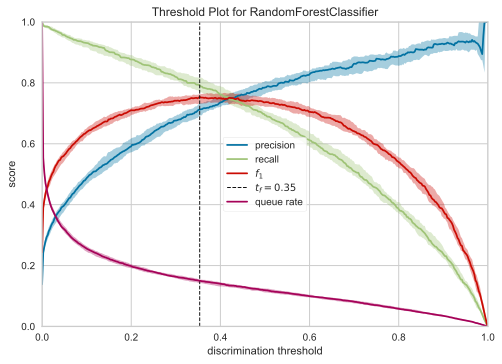

<AxesSubplot:title={'center':'Threshold Plot for RandomForestClassifier'}, xlabel='discrimination threshold', ylabel='score'>

In [45]:
visualizer = DiscriminationThreshold(best_model, quantiles=np.array([0.25, 0.5, 0.75]))

visualizer.fit(X_train, y_train)  #default: cv=0.1
visualizer.show() 

In [47]:
best_threshold = visualizer.thresholds_[visualizer.cv_scores_[visualizer.argmax].argmax()]
pipe = Thresholder(best_model, best_threshold, refit=False)
pipe.fit(X_train, y_train)

Thresholder(model=RandomForestClassifier(class_weight='balanced',
                                         criterion='entropy', max_features=None,
                                         n_estimators=1500),
            threshold=0.3535353535353536)

In [121]:
# F1 Score and corresponding Threshold
print('Random Forest cross validation results: Best Threshold =%f, F-Score=%.3f' % (best_threshold, grid_search.best_score_))

Random Forest cross validation results: Best Threshold =0.353535, F-Score=0.739


## After CV  is done

In [122]:
### 2. USE BEST PARAMETERS TO MAKE PREDICTIONS ON THE TEST SET 
#Best f1 score: 0.673 using {'criterion': 'entropy', 'max_features': None, 'min_samples_leaf': 1, 'n_estimators': 1000}
RFC_5 = RandomForestClassifier(n_estimators=1500, max_features=None, criterion='entropy')
RFC_5.fit(X_train,y_train)
y_pred_RFC_5 = RFC_5.predict(X_test)
probs_RFC_5 = RFC_5.predict_proba(X_test)

#ScoreRFC_4 = metrics.f1_score(y_test, y_pred_RFC_4)  
#cmRFC_4 = metrics.confusion_matrix(y_test, y_pred_RFC_4)
#metricsRFC_4 = metrics.classification_report(y_test, y_pred_RFC_4)

In [123]:
probs_RFC_5 = probs_RFC_5[:, 1]

In [124]:
y_pred = (probs_RFC_5 > best_threshold).astype('float')
confusion_matrix(y_test, y_pred)

array([[1614,  230],
       [ 407,  170]], dtype=int64)

In [179]:
precision_RFC_5, recall_RFC_5, threshold_RFC_5 = precision_recall_curve(y_test, probs_RFC_5)

In [ ]:
# f score = 0.347

## Re-build dataset

In [196]:
df_final = df1.drop('done', axis=1)

In [197]:
df_final = df_final[df_final['maintainance_year'] == 2022]

In [198]:
df_final['prediction'] = y_pred.tolist()

In [199]:
df_final = df_final.astype({'prediction': 'int32'})

In [200]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
  display(df_final)

,VESSEL_NAME,Running_Hours,Maintenance_Kit,Cylinder_Number,maintainance_year,prediction
84,Aqua Bonanza,76504.045455,Fuel Valve (16.000 hrs) B,1,2022,0
85,Aqua Bonanza,76504.045455,Cyl. Cover,1,2022,0
86,Aqua Bonanza,76504.045455,Exh. Valve Act,1,2022,0
87,Aqua Bonanza,76504.045455,Fuel Valve (16.000 hrs) A,1,2022,1
88,Aqua Bonanza,76504.045455,Fuel Pump,1,2022,1
89,Aqua Bonanza,76504.045455,Piston Ring CR,1,2022,0
90,Aqua Bonanza,76504.045455,Stuff. Box MK,1,2022,0
91,Aqua Bonanza,76504.045455,Turbocharger,1,2022,0
92,Aqua Bonanza,76504.045455,Cyl. Liner,1,2022,0
93,Aqua Bonanza,76504.045455,Hydr. Cyl. Unit,1,2022,0


This is the final Notebook, thank you for your time :)